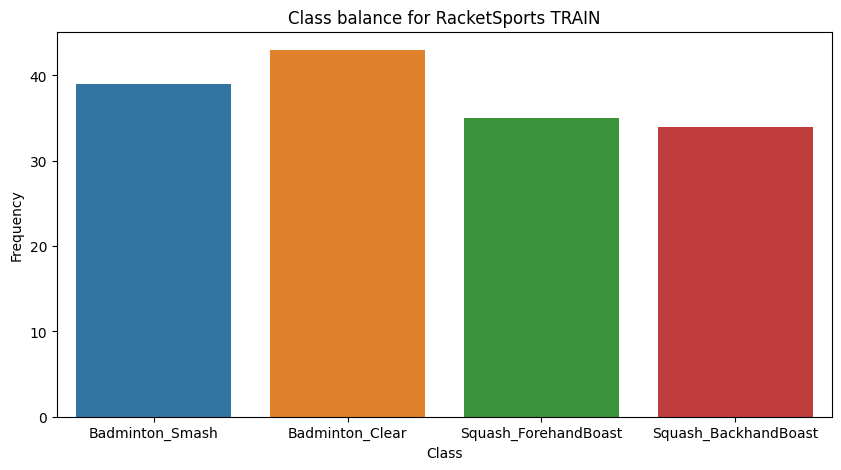

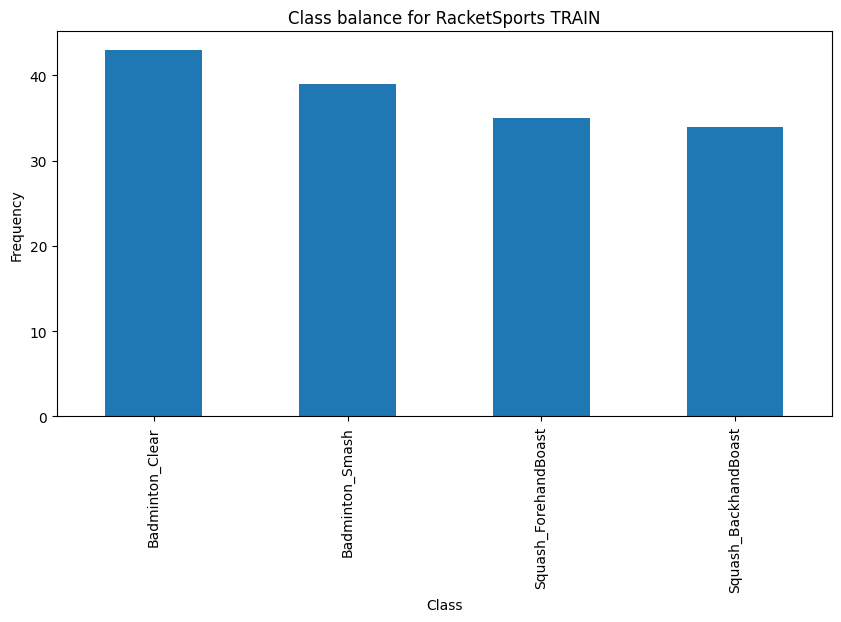

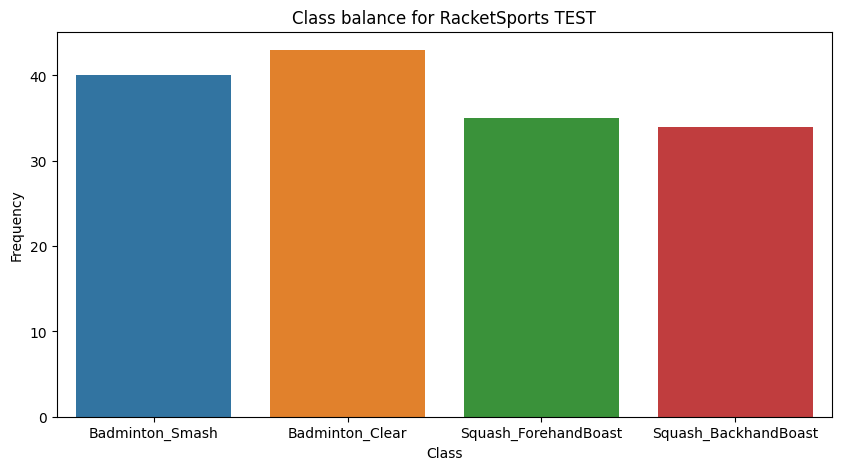

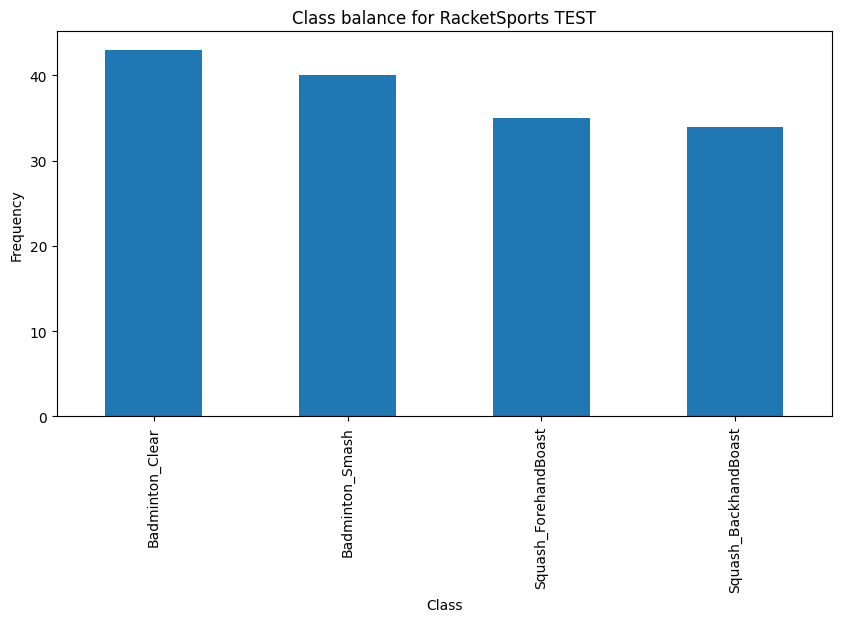

In [1]:
import pandas as pd
from sktime.datasets import load_from_arff_to_dataframe, load_from_tsfile_to_dataframe
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load train and test data
X_train, Y_train = load_from_arff_to_dataframe("RacketSports/RacketSports_TRAIN.arff")
X_test, Y_test = load_from_arff_to_dataframe("RacketSports/RacketSports_TEST.arff")


# removing null values
X_train = X_train.dropna()


# Function to plot class balance using seaborn countplot
def plot_class_balance_seaborn(labels, dataset_name):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=labels)
    plt.title(f"Class balance for {dataset_name}")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

# Function to plot class balance using pandas DataFrame plot.bar
def plot_class_balance_pandas(labels, dataset_name):
    class_counts = pd.Series(labels).value_counts()
    plt.figure(figsize=(10, 5))
    class_counts.plot.bar()
    plt.title(f"Class balance for {dataset_name}")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

# Training dataset
plot_class_balance_seaborn(Y_train, "RacketSports TRAIN")
plot_class_balance_pandas (Y_train, "RacketSports TRAIN")

# Test dataset
plot_class_balance_seaborn(Y_test, "RacketSports TEST")
plot_class_balance_pandas (Y_test, "RacketSports TEST")





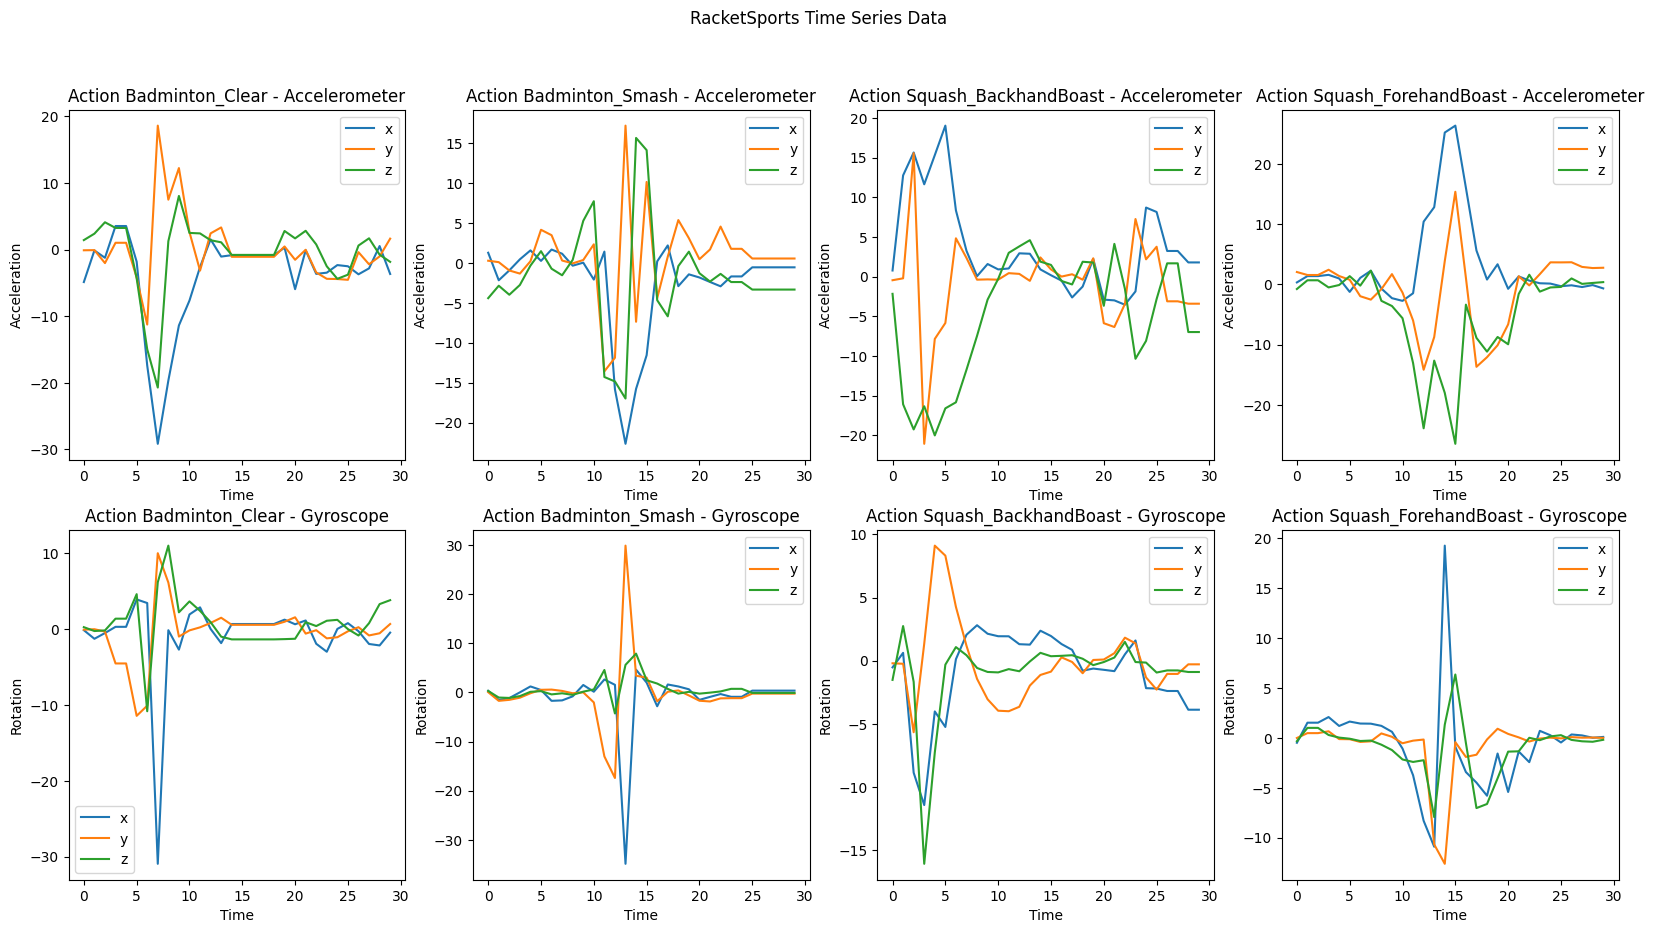

In [3]:
# First, encode the labels as integers for easier handling
le = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train)

# Find the indices of one example for each action
unique_actions, unique_action_indices = np.unique(Y_train_encoded, return_index=True)

# Initialize the plot
fig, axes = plt.subplots(nrows=2, ncols=len(unique_actions), figsize=(20, 10))
fig.suptitle("RacketSports Time Series Data")

# Iterate through each unique action
for i, action_index in enumerate(unique_action_indices):
    # Get accelerometer and gyroscope data for each action
    accelerometer_data = np.array([*X_train.iloc[action_index, :3].values]).T
    gyroscope_data = np.array([*X_train.iloc[action_index, 3:].values]).T

    # Plot accelerometer data
    axes[0, i].plot(accelerometer_data)
    axes[0, i].set_title(f"Action {le.classes_[i]} - Accelerometer")
    axes[0, i].set_xlabel("Time")
    axes[0, i].set_ylabel("Acceleration")
    axes[0, i].legend(["x", "y", "z"])

    # Plot gyroscope data
    axes[1, i].plot(gyroscope_data)
    axes[1, i].set_title(f"Action {le.classes_[i]} - Gyroscope")
    axes[1, i].set_xlabel("Time")
    axes[1, i].set_ylabel("Rotation")
    axes[1, i].legend(["x", "y", "z"])

# Display the plots
plt.show()

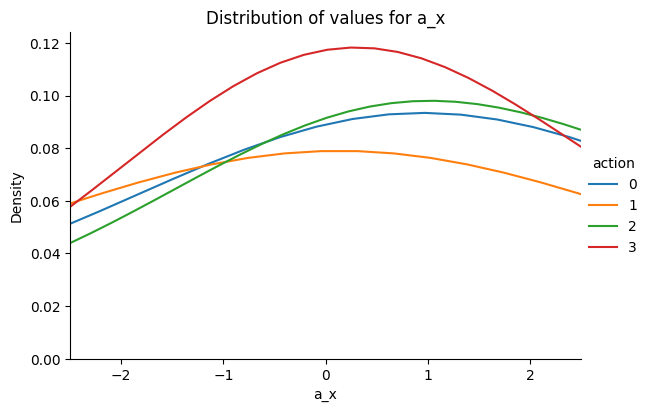

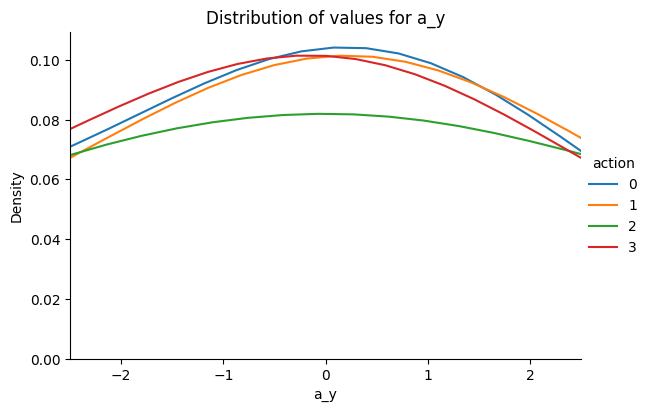

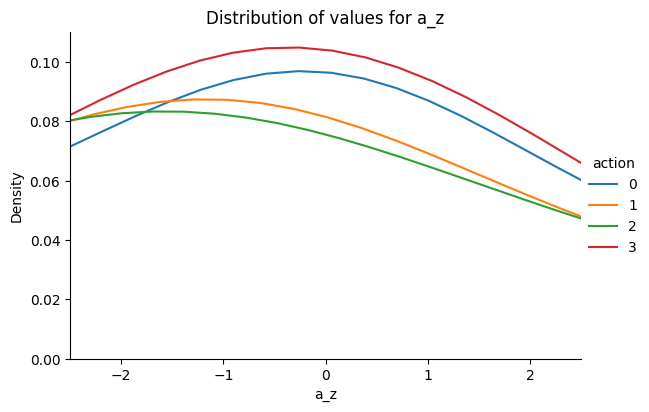

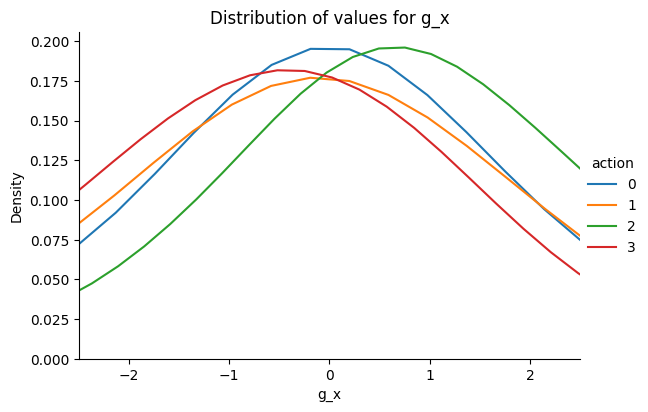

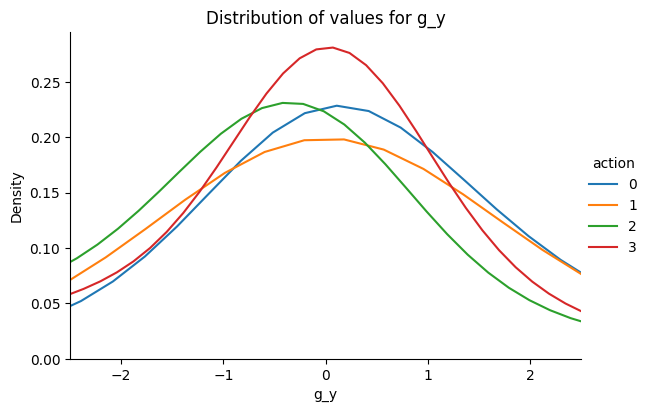

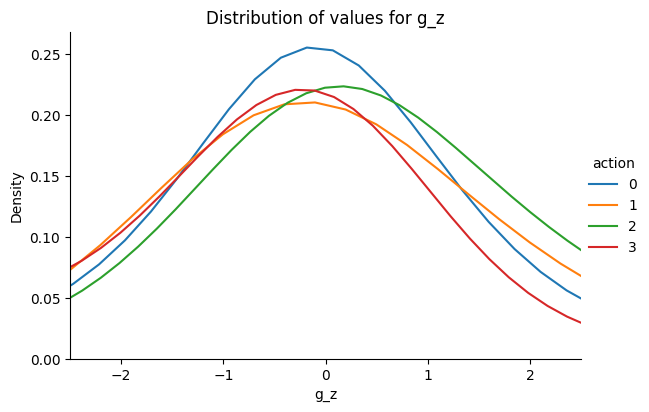

In [4]:
# First, let's encode the labels as integers for easier handling
le = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train)

# Create a new DataFrame with flattened accelerometer and gyroscope data per axis
data_list = []
for i, row in X_train.iterrows():
    accelerometer_data = np.array([*row[:3].values]).T
    gyroscope_data = np.array([*row[3:].values]).T
    for (a_x, a_y, a_z), (g_x, g_y, g_z) in zip(accelerometer_data, gyroscope_data):
        data_list.append([a_x, a_y, a_z, g_x, g_y, g_z, Y_train_encoded[i]])

columns = ["a_x", "a_y", "a_z", "g_x", "g_y", "g_z", "action"]
flat_data = pd.DataFrame(data_list, columns=columns)

# Plot the distribution of values per axis and action
for axis in ["a_x", "a_y", "a_z", "g_x", "g_y", "g_z"]:
    g = sns.FacetGrid(flat_data, hue="action", height=4, aspect=1.5)
    g.map(sns.kdeplot, axis).add_legend()
    g.set(xlim=(-2.5, 2.5))
    plt.title(f"Distribution of values for {axis}")
    plt.show()

In [12]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
import scipy.stats
from numpy.fft import fft

# Encode labels
le = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train)
Y_test_encoded = le.transform(Y_test)

def feature_extraction(row):
    accel_x = row['dim_0']
    accel_y = row['dim_1']
    accel_z = row['dim_2']
    gyro_x = row['dim_3']
    gyro_y = row['dim_4']
    gyro_z = row['dim_5']

    # Mean
    mean_ax = np.mean(accel_x)
    mean_ay = np.mean(accel_y)
    mean_az = np.mean(accel_z)
    mean_gx = np.mean(gyro_x)
    mean_gy = np.mean(gyro_y)
    mean_gz = np.mean(gyro_z)

    # Standard deviation
    std_ax = np.std(accel_x)
    std_ay = np.std(accel_y)
    std_az = np.std(accel_z)
    std_gx = np.std(gyro_x)
    std_gy = np.std(gyro_y)
    std_gz = np.std(gyro_z)

    # Minimum value
    min_ax = np.min(accel_x)
    min_ay = np.min(accel_y)
    min_az = np.min(accel_z)
    min_gx = np.min(gyro_x)
    min_gy = np.min(gyro_y)
    min_gz = np.min(gyro_z)

    # Maximum value
    max_ax = np.max(accel_x)
    max_ay = np.max(accel_y)
    max_az = np.max(accel_z)
    max_gx = np.max(gyro_x)
    max_gy = np.max(gyro_y)
    max_gz = np.max(gyro_z)

    median_ax = np.median(accel_x)
    median_ay = np.median(accel_y)
    median_az = np.median(accel_z)
    median_gx = np.median(gyro_x)
    median_gy = np.median(gyro_y)
    median_gz = np.median(gyro_z)

    mad_ax = np.median(np.abs(accel_x - np.median(accel_x)))
    mad_ay = np.median(np.abs(accel_y - np.median(accel_y)))
    mad_az = np.median(np.abs(accel_z - np.median(accel_z)))
    mad_gx = np.median(np.abs(gyro_x - np.median(gyro_x)))
    mad_gy = np.median(np.abs(gyro_y - np.median(gyro_y)))
    mad_gz = np.median(np.abs(gyro_z - np.median(gyro_z)))

    iqr_ax = np.percentile(accel_x, 75) - np.percentile(accel_x, 25)
    iqr_ay = np.percentile(accel_y, 75) - np.percentile(accel_y, 25)
    iqr_az = np.percentile(accel_z, 75) - np.percentile(accel_z, 25)
    iqr_gx = np.percentile(gyro_x, 75) - np.percentile(gyro_x, 25)
    iqr_gy = np.percentile(gyro_y, 75) - np.percentile(gyro_y, 25)
    iqr_gz = np.percentile(gyro_z, 75) - np.percentile(gyro_z, 25)

    skew_ax = scipy.stats.skew(accel_x)
    skew_ay = scipy.stats.skew(accel_y)
    skew_az = scipy.stats.skew(accel_z)
    skew_gx = scipy.stats.skew(gyro_x)
    skew_gy = scipy.stats.skew(gyro_y)
    skew_gz = scipy.stats.skew(gyro_z)

    kurt_ax = scipy.stats.kurtosis(accel_x)
    kurt_ay = scipy.stats.kurtosis(accel_y)
    kurt_az = scipy.stats.kurtosis(accel_z)
    kurt_gx = scipy.stats.kurtosis(gyro_x)
    kurt_gy = scipy.stats.kurtosis(gyro_y)
    kurt_gz = scipy.stats.kurtosis(gyro_z)

    # Signal energy
    energy_ax = np.mean(accel_x ** 2)
    energy_ay = np.mean(accel_y ** 2)
    energy_az = np.mean(accel_z ** 2)
    energy_gx = np.mean(gyro_x ** 2)
    energy_gy = np.mean(gyro_y ** 2)
    energy_gz = np.mean(gyro_z ** 2)

    # Mean resultant acceleration
    mean_resultant_accel = np.mean(np.sqrt(accel_x ** 2 + accel_y ** 2 + accel_z ** 2))

    # Signal magnitude area
    sma_accel = np.mean(np.abs(accel_x) + np.abs(accel_y) + np.abs(accel_z))
    sma_gyro = np.mean(np.abs(gyro_x) + np.abs(gyro_y) + np.abs(gyro_z))

    # Fast Fourier Transform (FFT)
    fft_ax = np.abs(fft(accel_x))
    fft_ay = np.abs(fft(accel_y))
    fft_az = np.abs(fft(accel_z))
    fft_gx = np.abs(fft(gyro_x))
    fft_gy = np.abs(fft(gyro_y))
    fft_gz = np.abs(fft(gyro_z))

    # Frequency domain features
    fft_mean_ax = np.mean(fft_ax)
    fft_mean_ay = np.mean(fft_ay)
    fft_mean_az = np.mean(fft_az)
    fft_mean_gx = np.mean(fft_gx)
    fft_mean_gy = np.mean(fft_gy)
    fft_mean_gz = np.mean(fft_gz)

    fft_std_ax = np.std(fft_ax)
    fft_std_ay = np.std(fft_ay)
    fft_std_az = np.std(fft_az)
    fft_std_gx = np.std(fft_gx)
    fft_std_gy = np.std(fft_gy)
    fft_std_gz = np.std(fft_gz)


    features = [
        mean_ax, mean_ay, mean_az, mean_gx, mean_gy, mean_gz,
        std_ax, std_ay, std_az, std_gx, std_gy, std_gz,
        min_ax, min_ay, min_az, min_gx, min_gy, min_gz,
        max_ax, max_ay, max_az, max_gx, max_gy, max_gz,
        median_ax, median_ay, median_az, median_gx, median_gy, median_gz,
        mad_ax, mad_ay, mad_az, mad_gx, mad_gy, mad_gz,
        iqr_ax, iqr_ay, iqr_az, iqr_gx, iqr_gy, iqr_gz,
        skew_ax, skew_ay, skew_az, skew_gx, skew_gy, skew_gz,
        kurt_ax, kurt_ay, kurt_az, kurt_gx, kurt_gy, kurt_gz,
        energy_ax, energy_ay, energy_az, energy_gx, energy_gy, energy_gz,
        mean_resultant_accel,
        sma_accel, sma_gyro,
        fft_mean_ax, fft_mean_ay, fft_mean_az, fft_mean_gx, fft_mean_gy, fft_mean_gz,
        fft_std_ax, fft_std_ay, fft_std_az, fft_std_gx, fft_std_gy, fft_std_gz
    ]

    return features

def evaluate_classifier(classifier, X_train, y_train, scoring='accuracy'):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(classifier, X_train, y_train, cv=cv, scoring=scoring)
    return scores.mean(), scores.std()

# Feature extraction
X_train_features = np.array([feature_extraction(row) for _, row in X_train.iterrows()])
X_test_features = np.array([feature_extraction(row) for _, row in X_test.iterrows()])

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# Feature selection
selector = SelectPercentile(percentile=100)
X_train_selected = selector.fit_transform(X_train_scaled, Y_train_encoded)
X_test_selected = selector.transform(X_test_scaled)  # Select features from test data with the same selector

# Define classifiers
rf = RandomForestClassifier()
xgb = XGBClassifier()
svm = SVC()

classifiers = {'Random Forest': rf, 'XGBoost': xgb, 'SVM': svm}

# Evaluate classifiers
for name, classifier in classifiers.items():
    mean_acc, std_acc = evaluate_classifier(classifier, X_train_selected, Y_train_encoded)
    print(f"{name}: Mean Accuracy: {mean_acc:.4f}, Std: {std_acc:.4f}")

# Define hyperparameters
rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
}

xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 10, 15],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
}

svm_params = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
}

params = {
    'Random Forest': rf_params,
    'XGBoost': xgb_params,
    'SVM': svm_params
}

best_params_dict = {}


# Replace the GridSearchCV block with the following:
all_results = []

for name, classifier in classifiers.items():
    grid_search = GridSearchCV(classifier, params[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_selected, Y_train_encoded)
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    best_params_dict[name] = best_params

    print(f"{name}: Best Params: {best_params}, Best Score: {best_score:.4f}")

    # Store all results in a list
    for i, params_combination in enumerate(grid_search.cv_results_['params']):
        result_row = {
            'Classifier': name,
            'Params': params_combination,
            'Mean Accuracy': grid_search.cv_results_['mean_test_score'][i],
            'Std Accuracy': grid_search.cv_results_['std_test_score'][i],
        }
        all_results.append(result_row)

# Create a DataFrame to display the results
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by=['Classifier', 'Mean Accuracy'], ascending=[True, False])
pd.set_option('display.max_colwidth', None)
display(results_df)
# Export to CSV
results_df.to_csv("all_grid_search_results.csv", index=False)



# GridSearchCV
for name, classifier in classifiers.items():
    grid_search = GridSearchCV(classifier, params[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_selected, Y_train_encoded)
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    best_params_dict[name] = best_params
    
    print(f"{name}: Best Params: {best_params}, Best Score: {best_score:.4f}")


# Train and evaluate each model with the best hyperparameters
for model_name, model in classifiers.items():
    model.fit(X_train_selected, Y_train_encoded)
    y_pred = model.predict(X_test_selected)
    
    print(f"Model: {model_name}")
    print("Best Hyperparameters:", best_params_dict[model_name])
    print(classification_report(Y_test_encoded, y_pred, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(Y_test_encoded, y_pred))
    print("\n")





Random Forest: Mean Accuracy: 0.8673, Std: 0.0371
XGBoost: Mean Accuracy: 0.8015, Std: 0.0754
SVM: Mean Accuracy: 0.8473, Std: 0.0691
Random Forest: Best Params: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 500}, Best Score: 0.8740
XGBoost: Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}, Best Score: 0.7815
SVM: Best Params: {'C': 1, 'kernel': 'rbf'}, Best Score: 0.8804


,Classifier,Params,Mean Accuracy,Std Accuracy
7,Random Forest,"{'max_depth': None, 'max_features': 'log2', 'n_estimators': 500}",0.873978,0.077406
21,Random Forest,"{'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}",0.867527,0.055804
27,Random Forest,"{'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 500}",0.861075,0.076830
30,Random Forest,"{'max_depth': 30, 'max_features': 'log2', 'n_estimators': 300}",0.861075,0.064227
4,Random Forest,"{'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}",0.860860,0.057475
...,...,...,...,...
77,XGBoost,"{'learning_rate': 0.001, 'max_depth': 15, 'n_estimators': 200}",0.681935,0.058908
80,XGBoost,"{'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 100}",0.681720,0.070046
81,XGBoost,"{'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 200}",0.681720,0.070046
82,XGBoost,"{'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 300}",0.681720,0.070046


ModuleNotFoundError: No module named 'openpyxl'